# Stage 2: Bayesian Gaussian Mixture Model for Galaxy Morphology Clustering

**Authors:** Tina Sikharulidze, Albert Lamb, Michael Duarte Gonçalves

**Date:** December 2025

---

This notebook implements Stage 2 of our unsupervised galaxy classification pipeline. Our goal is to discover natural groupings among galaxies based purely on their visual features, without relying on human-provided labels during training.

### What We're Doing in Stage 2

Now that we have these compact galaxy representations, our task is to find natural groupings or clusters among them. We use a Bayesian Gaussian Mixture Model (GMM) to discover these clusters automatically. The key insight is that if the VAE learned meaningful features, galaxies with similar morphologies (e.g., ellipticals, spirals) should cluster together in the latent space.

A Gaussian Mixture Model assumes that our data was generated by a mixture of several Gaussian (normal) distributions, each representing a distinct cluster. The model learns the parameters of these Gaussians: their centers (means), shapes (covariances), and relative sizes (mixture weights).

### Why Bayesian? Why Gibbs Sampling?

Instead of seeking a single best answer, we explore the full landscape of plausible parameter values and characterize their probabilities using Bayesian Inference with Gibbs Sampling. This gives us:

- Uncertainty quantification: We obtain full posterior distributions, telling us not just *what* the parameters likely are, but *how confident* we should be in those estimates
- Natural regularization: Prior distributions encode reasonable assumptions and prevent the model from overfitting to noise
- Robust inference: By averaging over many parameter configurations, we get more stable and reliable results

Gibbs sampling makes Bayesian inference tractable for complex models. The key insight is that while sampling from the full joint posterior is intractable, sampling from each parameter's conditional distribution (given all other parameters) is often straightforward. By iteratively cycling through all parameters—updating each one while holding the others fixed—the samples eventually converge to the true joint posterior distribution. It's like solving a complex puzzle by focusing on one piece at a time: eventually, all the pieces fall into place.

---
## Setup and Imports

We begin by importing all the libraries we need for this analysis.

In [11]:
# Core libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pathlib import Path

# Statistics
from scipy import stats
from scipy.stats import invwishart, dirichlet, multivariate_normal

# Machine learning
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Python utilities
from dataclasses import dataclass
from typing import Dict, Tuple
from tqdm import tqdm
from PIL import Image
import io
import warnings

warnings.filterwarnings('ignore')

---
## Configuration

**Key parameters explained:**

- `K_VALUES = range(3, 11)`: We explore models with 3 to 10 clusters. We selected this range because galaxies exhibit a handful of major morphological types (ellipticals, spirals, irregulars, and their subtypes), so we expect the optimal $K$ to be in this range.

- `N_ITERATIONS = 5000`: Total number of Gibbs sampling iterations. This needs to be large enough for the Markov chain to converge and explore the posterior adequately.

- `BURN_IN = 1000`: The first 1,000 samples are discarded. Early samples are influenced by our arbitrary initialization and don't represent the true posterior.

In [12]:
# Reproducibility
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

# Model selection
K_VALUES = range(3, 11)
N_ITERATIONS = 5000
BURN_IN = 1000

# Directories
FIGURES_DIR = Path('output/figures/')
TABLES_DIR = Path('output/tables/')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.figsize': (10, 6), 'font.size': 12})

SCATTER_STYLE = dict(alpha=0.5, s=8)
SAVE_DPI = 150

print("Configuration loaded")

Configuration loaded


---
## Helper Functions

We define reusable utility functions that will be used throughout the notebook. These small, focused functions make our code more readable:

- **`save_figure`**: Handles figure saving with consistent settings and provides feedback about saved files. This prevents us from repeating the same saving everywhere.

- **`set_axis_labels`**: Since most of our plots use t-SNE projections with the same axis labels, this function eliminates redundancy when labeling multiple subplots.

- **`figure_to_image`**: Converts matplotlib figures to PIL Images, which we need for creating animated GIFs. This involves rendering the figure to an in-memory buffer and reading it back as an image object.

In [13]:
def save_figure(fig, save_path, dpi=SAVE_DPI):
    """We save a figure and print confirmation."""
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Saved: {save_path}")


def set_axis_labels(axes, xlabel='t-SNE 1', ylabel='t-SNE 2'):
    """We add axis labels to one or more axes."""
    if not hasattr(axes, '__iter__'):
        axes = [axes]
    for ax in axes:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)


def figure_to_image(fig):
    """We convert a matplotlib figure to a PIL Image for GIF creation."""
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=120, bbox_inches='tight')
    buf.seek(0)
    image = Image.open(buf).copy()
    buf.close()
    return image

---
## Load the Data from Stage 1

Here we load the outputs from Stage 1 of our pipeline. Two files are essential:

**1. `latent_representations.npy`** — This is an N × 16 matrix where each row is a galaxy's latent vector. These 16-dimensional representations are what our VAE learned to extract from raw images. Each dimension captures some aspect of galaxy morphology, though the exact meaning of each dimension is not immediately interpretable.

**2. `galaxy_metadata.csv`** — Contains Galaxy Zoo labels derived from citizen science classifications. This is a subsample of our original dataset.

**Important note**: We do *not* use Galaxy Zoo labels during clustering. Our Bayesian GMM discovers clusters in a completely unsupervised manner. We only use these labels *after* clustering to validate whether our discovered clusters correspond to meaningful morphological categories. This is the key test of whether our VAE learned astronomically relevant features.

The summary statistics we print help us understand the data distribution. For example, whether the latent space is roughly centered at zero as we'd expect from a VAE with a standard normal prior.

In [14]:
# We load the data
Z = np.load('../data/latent_representations.npy')
metadata = pd.read_csv('../data/galaxy_metadata.csv')

# We extract dimensions
N, d = Z.shape

# We print a summary
print(f"Number of galaxies: {N:,}")
print(f"Latent dimension: {d}")
print(f"\n\nLatent space statistics:")
print(f"Mean: {Z.mean():.4f}")
print(f"Std: {Z.std():.4f}")
print(f"Range: [{Z.min():.4f}, {Z.max():.4f}]")

Number of galaxies: 7,504
Latent dimension: 16


Latent space statistics:
Mean: 0.0017
Std: 0.8505
Range: [-5.4607, 8.8808]


---
## Visualize the Latent Space

Our latent space has 16 dimensions, which is impossible to visualize directly. To gain intuition about its structure, we use t-SNE (t-Distributed Stochastic Neighbor Embedding) to project it down to 2 dimensions.

### How t-SNE Works

t-SNE is a nonlinear dimensionality reduction technique that excels at preserving local structure. It works by:
1. Computing pairwise similarities between points in the high-dimensional space
2. Finding a low-dimensional arrangement where similar points stay close together
3. Minimizing the difference between high-D and low-D similarity distributions

### Important Caveats

While t-SNE produces beautiful visualizations, we must interpret them carefully:

- Axes are arbitrary: The x and y coordinates have no physical meaning—only relative positions matter
- Distances between distant clusters are unreliable: t-SNE distorts global structure to preserve local neighborhoods
- Cluster sizes can be misleading: Dense regions may appear artificially expanded
- Results vary with random seeds: Different runs can produce different-looking plots (hence our fixed seed)

Despite these limitations, t-SNE is invaluable for visual exploration. In our visualization, we color points by Galaxy Zoo classifications to see whether the VAE has naturally organized galaxies by morphology—even though it was never explicitly trained to do so.

The perplexity parameter (set to 30) roughly controls how many neighbors each point considers. We use 30 as a default.

Running t-SNE (this takes a bit)...
Done
Saved: output/figures/01_latent_space_visualization.png


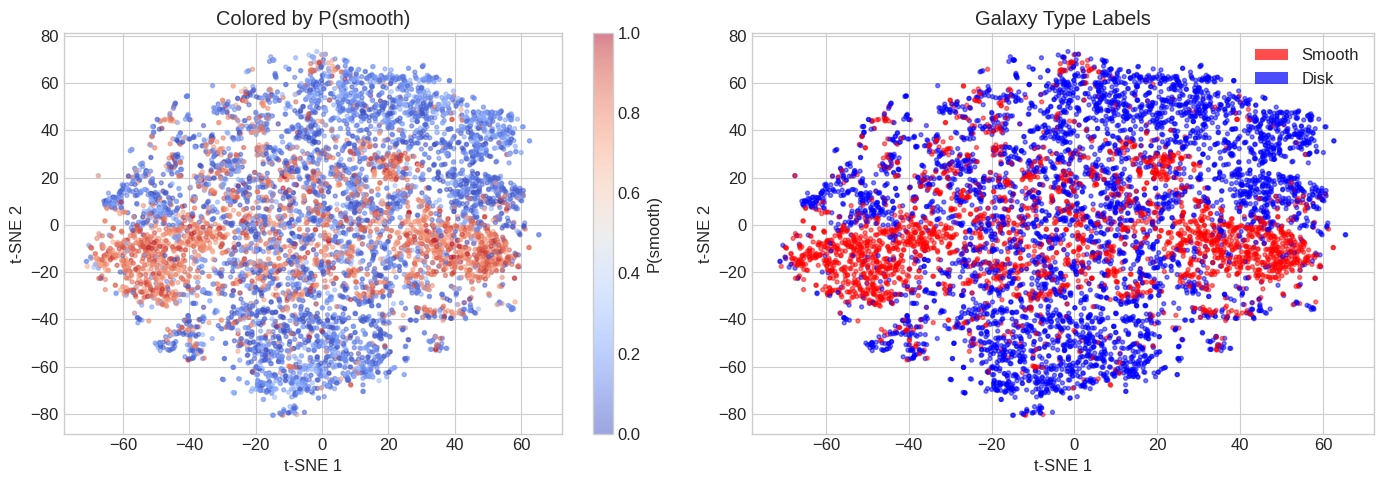

In [15]:
def plot_latent_space(Z_2d, metadata, save_path=None):
    """We visualize the latent space with t-SNE projection."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: P(smooth) continuous
    sc = axes[0].scatter(
        Z_2d[:, 0], Z_2d[:, 1],
        c=metadata['p_smooth'],
        cmap='coolwarm',
        **SCATTER_STYLE
    )
    plt.colorbar(sc, ax=axes[0], label='P(smooth)')
    axes[0].set_title('Colored by P(smooth)')
    
    # Right: Binary labels
    colors = metadata['is_smooth'].map({True: 'red', False: 'blue'})
    axes[1].scatter(Z_2d[:, 0], Z_2d[:, 1], c=colors, **SCATTER_STYLE)
    axes[1].legend(handles=[
        Patch(facecolor='red', alpha=0.7, label='Smooth'),
        Patch(facecolor='blue', alpha=0.7, label='Disk')
    ])
    axes[1].set_title('Galaxy Type Labels')
    
    set_axis_labels(axes)
    plt.tight_layout()
    save_figure(fig, save_path)
    plt.show()


# We run t-SNE
print("Running t-SNE (this takes a bit)...")
Z_tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, max_iter=1000).fit_transform(Z)
print("Done")

plot_latent_space(Z_tsne, metadata, FIGURES_DIR / '01_latent_space_visualization.png')

---
## Hyperparameters

In Bayesian inference, hyperparameters define our prior beliefs about the model parameters before seeing any data. The choice of priors is important: they should be "weakly informative"—encoding reasonable assumptions without overwhelming the evidence from the data.

Our prior choices and their justifications:

| Parameter | Prior | Value | Justification |
|-----------|-------|-------|---------------|
| **Mixture weights ($\pi$)** | Dirichlet($\alpha$) | $\alpha = 1$ | We have no prior preference for any cluster being larger than others. $\alpha = 1$ gives a uniform distribution. |
| **Cluster means ($\mu$)** | Normal($m_0$, $S_0$) | $m_0 = 0$, $S_0 = 10I$ | VAE latent spaces are typically centered near zero. The large variance (10) allows means to be anywhere reasonable. |
| **Cluster covariances ($\Sigma$)** | Inverse-Wishart($\nu_0$, $\Psi_0$) | $\nu_0 = d+2$, $\Psi_0 = I$ | $\nu_0 = d+2$ is the minimum degrees of freedom that gives a proper distribution with finite mean. The identity scale matrix expresses no prior preference for any particular covariance structure. |

### Why These Priors Are "Weakly Informative"

- **Uniform Dirichlet ($\alpha=1$)**: Any allocation of cluster sizes is equally likely *a priori*. With enough data, the posterior will be dominated by evidence.

- **Wide Normal for means**: $S_0 = 10I$ means cluster centers could be anywhere within $\approx6$ standard deviations of the origin (covers essentially the entire latent space).

- **Minimum-information Inverse-Wishart**: By setting $\nu_0$ to the minimum valid value, we let the data drive the covariance estimates rather than imposing strong prior constraints.

The `@dataclass` decorator provides a clean way to bundle these hyperparameters together, with a factory method to create the standard weakly-informative configuration.

In [16]:
@dataclass
class Hyperparameters:
    """We store all hyperparameters for the Bayesian GMM."""
    alpha: np.ndarray
    m0: np.ndarray
    S0: np.ndarray
    nu0: int
    Psi0: np.ndarray
    
    @classmethod
    def weakly_informative(cls, d: int, K: int) -> 'Hyperparameters':
        """We create weakly informative priors."""
        return cls(
            alpha=np.ones(K),
            m0=np.zeros(d),
            S0=10.0 * np.eye(d),
            nu0=d + 2,
            Psi0=np.eye(d)
        )

---
## The Bayesian GMM Class

This is the heart of our analysis: a complete implementation of Bayesian Gaussian Mixture Model inference via Gibbs sampling. Our implementation follows the classical conjugate prior formulation, which allows each conditional distribution to be sampled analytically.

### The Gibbs Sampling Algorithm

Each iteration of our Gibbs sampler performs four sequential updates or steps:

1. Sample cluster assignments ($z$): For each galaxy, we compute the probability it belongs to each cluster (based on current parameters) and sample a new assignment from this categorical distribution.

2. Sample mixture weights ($\pi$): Given the cluster assignments, we update the mixture weights. The conjugate prior for a categorical likelihood is the Dirichlet distribution, so our posterior is Dirichlet($\alpha + counts$).

3. Sample cluster means ($\mu$): For each cluster, we compute the posterior mean and covariance (combining the prior with the observed cluster members) and sample from this Normal distribution.

4. Sample cluster covariances ($\Sigma$): The conjugate prior for covariance matrices is the Inverse-Wishart distribution. We update each cluster's covariance by combining the prior with the scatter matrix of its members.

### Burn-in

- MCMC samplers need time to "forget" their initialization and converge to the target distribution. The samples from this transient period are not representative of the posterior and must be discarded. This is called **burn-in**.

- We use 1,000 burn-in iterations out of 5,000 total. After burn-in, we retain 4,000 samples that (assuming convergence) are draws from the true posterior distribution.

### Implementation Details

- k-means++ initialization: Rather than random initialization, we use k-means to choose well-separated initial cluster centers. This dramatically improves convergence speed.

- Log-space computation: To avoid numerical underflow when computing responsibilities (products of many small probabilities), we work in log-space and use the log-sum-exp trick.

- Posterior summarization: After sampling, we summarize the posterior using the mean of the samples (for $\pi, \mu, \Sigma$) and the mode of assignments (most frequent cluster assignment for each galaxy).

In [17]:
class BayesianGMM:
    """Bayesian GMM with Gibbs Sampling."""
    
    def __init__(self, K: int, hyperparams: Hyperparameters):
        """We initialize the model."""
        self.K = K
        self.hp = hyperparams
        self.S0_inv = np.linalg.inv(hyperparams.S0)
    
    def _initialize_parameters(self, Z: np.ndarray):
        """We set initial values using k-means++ style."""
        self.N, self.d = Z.shape
        self.pi = np.ones(self.K) / self.K
        self.Sigma = np.tile(np.eye(self.d), (self.K, 1, 1))
        self.assignments = np.random.randint(0, self.K, self.N)
        
        # We use k-means++ initialization for better convergence
        self.mu = np.zeros((self.K, self.d))
        self.mu[0] = Z[np.random.choice(self.N)]
        
        for k in range(1, self.K):
            dists = np.array([np.sum((Z - self.mu[j])**2, axis=1) for j in range(k)])
            min_dists = np.min(dists, axis=0)
            probs = min_dists / min_dists.sum()
            self.mu[k] = Z[np.random.choice(self.N, p=probs)]
    
    def _compute_log_responsibilities(self, Z: np.ndarray) -> np.ndarray:
        """We compute log responsibilities for numerical stability."""
        log_resp = np.full((self.N, self.K), -np.inf)
        
        for k in range(self.K):
            try:
                mvn = multivariate_normal(self.mu[k], self.Sigma[k], allow_singular=True)
                log_resp[:, k] = np.log(self.pi[k] + 1e-10) + mvn.logpdf(Z)
            except ValueError:
                pass
        
        return log_resp
    
    def _step1_sample_assignments(self, Z: np.ndarray):
        """Step 1: We sample cluster assignments."""
        log_resp = self._compute_log_responsibilities(Z)
        log_resp_shifted = log_resp - log_resp.max(axis=1, keepdims=True)
        probs = np.exp(log_resp_shifted)
        probs = probs / probs.sum(axis=1, keepdims=True)
        
        for n in range(self.N):
            self.assignments[n] = np.random.choice(self.K, p=probs[n])
    
    def _step2_sample_weights(self) -> np.ndarray:
        """Step 2: We sample mixture weights from Dirichlet posterior."""
        counts = np.bincount(self.assignments, minlength=self.K)
        self.pi = dirichlet.rvs(self.hp.alpha + counts)[0]
        return counts
    
    def _step3_sample_means(self, Z: np.ndarray):
        """Step 3: We sample cluster means from Normal posterior."""
        for k in range(self.K):
            mask = (self.assignments == k)
            n_k = mask.sum()
            
            if n_k == 0:
                self.mu[k] = multivariate_normal.rvs(self.hp.m0, self.hp.S0)
                continue
            
            z_bar = Z[mask].mean(axis=0)
            Sigma_k_inv = np.linalg.inv(self.Sigma[k])
            S_post_inv = self.S0_inv + n_k * Sigma_k_inv
            S_post = np.linalg.inv(S_post_inv)
            m_post = S_post @ (self.S0_inv @ self.hp.m0 + n_k * Sigma_k_inv @ z_bar)
            self.mu[k] = multivariate_normal.rvs(m_post, S_post)
    
    def _step4_sample_covariances(self, Z: np.ndarray):
        """Step 4: We sample covariances from Inverse-Wishart posterior."""
        for k in range(self.K):
            mask = (self.assignments == k)
            n_k = mask.sum()
            
            nu_post = self.hp.nu0 + n_k
            Psi_post = self.hp.Psi0.copy()
            
            if n_k > 0:
                diff = Z[mask] - self.mu[k]
                Psi_post = Psi_post + diff.T @ diff
            
            try:
                self.Sigma[k] = invwishart.rvs(nu_post, Psi_post)
            except ValueError:
                self.Sigma[k] = invwishart.rvs(nu_post, Psi_post + 1e-6 * np.eye(self.d))
    
    def _compute_log_likelihood(self, Z: np.ndarray) -> float:
        """We compute the data log-likelihood."""
        log_resp = self._compute_log_responsibilities(Z)
        return np.sum(np.log(np.exp(log_resp).sum(axis=1) + 1e-300))
    
    def fit(self, Z: np.ndarray, n_iterations: int = 5000,
            burn_in: int = 1000, verbose: bool = True) -> Tuple[Dict, Dict]:
        """We run the Gibbs sampler."""
        self._initialize_parameters(Z)
        n_samples = n_iterations - burn_in
        
        samples = {
            'pi': np.zeros((n_samples, self.K)),
            'mu': np.zeros((n_samples, self.K, self.d)),
            'Sigma': np.zeros((n_samples, self.K, self.d, self.d)),
            'assignments': np.zeros((n_samples, self.N), dtype=int),
            'log_likelihood': np.zeros(n_samples)
        }
        
        trace = {
            'log_likelihood': np.zeros(n_iterations),
            'pi': np.zeros((n_iterations, self.K))
        }
        
        iterator = tqdm(range(n_iterations), desc=f'Gibbs (K={self.K})') if verbose else range(n_iterations)
        
        for t in iterator:
            self._step1_sample_assignments(Z)
            self._step2_sample_weights()
            self._step3_sample_means(Z)
            self._step4_sample_covariances(Z)
            
            ll = self._compute_log_likelihood(Z)
            trace['log_likelihood'][t] = ll
            trace['pi'][t] = self.pi.copy()
            
            if t >= burn_in:
                idx = t - burn_in
                samples['pi'][idx] = self.pi.copy()
                samples['mu'][idx] = self.mu.copy()
                samples['Sigma'][idx] = self.Sigma.copy()
                samples['assignments'][idx] = self.assignments.copy()
                samples['log_likelihood'][idx] = ll
        
        self.posterior_pi = samples['pi'].mean(axis=0)
        self.posterior_mu = samples['mu'].mean(axis=0)
        self.posterior_Sigma = samples['Sigma'].mean(axis=0)
        self.final_assignments = stats.mode(samples['assignments'], axis=0, keepdims=False)[0]
        
        return samples, trace
    
    def sample_from_cluster(self, k: int, n_samples: int = 100, random_state: int = None) -> np.ndarray:
        """We generate new latent vectors from a cluster."""
        return multivariate_normal.rvs(
            mean=self.posterior_mu[k],
            cov=self.posterior_Sigma[k],
            size=n_samples,
            random_state=random_state
        )

---
## Model Selection with BIC

A fundamental question in clustering is: how many clusters should we use? Unlike supervised learning where we can use cross-validation, unsupervised clustering requires different criteria.

We use the Bayesian Information Criterion (BIC), which balances model fit against complexity:

$$\text{BIC} = -2 \cdot \log(L) + k \cdot \log(N)$$

where:
- $\log(L)$ is the log-likelihood (how well the model fits the data)
- $k$ is the number of free parameters (model complexity)
- $N$ is the number of data points

Main takeaway: adding more clusters always improves fit, but BIC asks whether the improvement justifies the additional parameters.

### Parameter Counting for GMMs

For a GMM with K clusters in d dimensions, we must estimate:

| Component | Parameters | Formula |
|-----------|------------|----------|
| Mixture weights | $K-1$ | They sum to 1, so one is determined (not free) |
| Means | $K \times d$ | ($K$ vectors of length d) |
| Covariances | $K \times \dfrac{d(d+1)}{2}$ | $\Sigma$ is symmetric $\iff$ for every $i, j$ we have $a_{ij} = a_{ji}$. They have $\dfrac{d(d+1)}{2}$ unique entries |

For our 16-dimensional latent space, each additional cluster adds 16 + 136 + 1 = 153 parameters. The BIC penalty ensures we don't add clusters frivolously.

**Note**: While we use BIC for model selection, other criteria exist (AIC, *etc.*). BIC is popular because it's consistent (asymptotically selects the true model) and easy to compute.

In [18]:
def compute_bic(log_likelihood: float, K: int, d: int, N: int) -> float:
    """We compute the Bayesian Information Criterion."""
    n_params = (K - 1) + K * d + K * d * (d + 1) // 2 # "integer" division (// 2), to avoid fractional number (e.g. 2.5 parameters, rounded to floor 2)
    return -2 * log_likelihood + n_params * np.log(N)


# We show parameter counts
print("Parameters for each K:")
for K in K_VALUES:
    n_params = (K - 1) + K * d + K * d * (d + 1) // 2
    print(f"K={K}: {n_params} parameters")

Parameters for each K:
K=3: 458 parameters
K=4: 611 parameters
K=5: 764 parameters
K=6: 917 parameters
K=7: 1070 parameters
K=8: 1223 parameters
K=9: 1376 parameters
K=10: 1529 parameters


---
## Run the Gibbs Sampler for Each K

Now we execute the core computational work of this notebook: fitting Bayesian GMMs for each candidate number of clusters ($K = 3, 4, \ldots, 10$).

For each $K$, we:

1. Create hyperparameters: Using our weakly informative prior specification
2. Initialize the model: With k-means++ style seeding for faster convergence
3. Run 5,000 Gibbs iterations: Discarding the first 1,000 as burn-in
4. Compute BIC: Using the mean log-likelihood from post-burn-in samples
5. Store everything: Posterior samples, trace plots, and summary statistics

This is the most computationally intensive part of the analysis. The progress bars (via tqdm) help us monitor the sampling progress and estimate completion time.

After fitting all models, we'll compare their BIC values to select the optimal number of clusters. The cluster sizes printed after each fit give us an immediate sense of whether the model has found reasonable structure (we should be suspicious of models with very unequal cluster sizes or empty clusters).

In [19]:
print("Model Selection")
print(f"\tK values: {list(K_VALUES)}")
print(f"\tIterations: {N_ITERATIONS} (burn-in: {BURN_IN})")
print("\n")

results = {}

for K in K_VALUES:
    print(f"Fitting K={K}...")
    
    model = BayesianGMM(K, Hyperparameters.weakly_informative(d, K))
    samples, trace = model.fit(Z, N_ITERATIONS, BURN_IN)
    
    mean_log_lik = samples['log_likelihood'].mean()
    bic = compute_bic(mean_log_lik, K, d, N)
    
    results[K] = {
        'model': model,
        'samples': samples,
        'trace': trace,
        'bic': bic,
        'mean_log_lik': mean_log_lik
    }
    
    sizes = np.bincount(model.final_assignments, minlength=K)
    print(f"\tLog-lik: {mean_log_lik:.2f}, BIC: {bic:.2f}, Sizes: {list(sizes)}")

print("\nDone!")

Model Selection
	K values: [3, 4, 5, 6, 7, 8, 9, 10]
	Iterations: 5000 (burn-in: 1000)


Fitting K=3...


Gibbs (K=3):   0%|          | 0/5000 [00:00<?, ?it/s]

Gibbs (K=3): 100%|██████████| 5000/5000 [06:23<00:00, 13.04it/s]


	Log-lik: -87814.85, BIC: 179716.52, Sizes: [np.int64(2617), np.int64(3384), np.int64(1503)]
Fitting K=4...


Gibbs (K=4): 100%|██████████| 5000/5000 [06:25<00:00, 12.96it/s]


	Log-lik: -85889.24, BIC: 177230.55, Sizes: [np.int64(1383), np.int64(3004), np.int64(2132), np.int64(985)]
Fitting K=5...


Gibbs (K=5): 100%|██████████| 5000/5000 [06:20<00:00, 13.14it/s]


	Log-lik: -85217.95, BIC: 177253.22, Sizes: [np.int64(2122), np.int64(2737), np.int64(931), np.int64(1382), np.int64(332)]
Fitting K=6...


Gibbs (K=6): 100%|██████████| 5000/5000 [05:21<00:00, 15.54it/s]


	Log-lik: -84961.16, BIC: 178104.89, Sizes: [np.int64(2080), np.int64(558), np.int64(2605), np.int64(893), np.int64(12), np.int64(1356)]
Fitting K=7...


Gibbs (K=7): 100%|██████████| 5000/5000 [05:30<00:00, 15.14it/s]


	Log-lik: -84417.21, BIC: 178382.23, Sizes: [np.int64(2107), np.int64(2632), np.int64(173), np.int64(441), np.int64(3), np.int64(1353), np.int64(795)]
Fitting K=8...


Gibbs (K=8): 100%|██████████| 5000/5000 [05:39<00:00, 14.72it/s]


	Log-lik: -83651.13, BIC: 178215.33, Sizes: [np.int64(2057), np.int64(323), np.int64(337), np.int64(2228), np.int64(1280), np.int64(741), np.int64(534), np.int64(4)]
Fitting K=9...


Gibbs (K=9): 100%|██████████| 5000/5000 [05:48<00:00, 14.35it/s]


	Log-lik: -82603.04, BIC: 177484.40, Sizes: [np.int64(2045), np.int64(731), np.int64(2095), np.int64(330), np.int64(328), np.int64(1288), np.int64(207), np.int64(184), np.int64(296)]
Fitting K=10...


Gibbs (K=10): 100%|██████████| 5000/5000 [05:34<00:00, 14.97it/s]


	Log-lik: -82237.41, BIC: 178118.39, Sizes: [np.int64(382), np.int64(265), np.int64(2027), np.int64(299), np.int64(6), np.int64(1170), np.int64(370), np.int64(696), np.int64(309), np.int64(1980)]

Done!


---
## Convergence Diagnostics

Before trusting our posterior samples, we must verify that the Gibbs sampler has converged—i.e., that it has reached and is sampling from the stationary (posterior) distribution.

### What Good Convergence Looks Like

We examine the trace plot of log-likelihood over iterations. A well-converged chain exhibits:

1. Stationarity: After an initial transient, the trace should fluctuate around a stable level without systematic trends

2. Good mixing: The chain should move freely through the parameter space, not getting "stuck" in any region for extended periods. Rapid up-and-down oscillations indicate good mixing.

3. Burn-in adequacy: There should be a visible difference in behavior before and after the burn-in period (red dashed line). The burn-in samples should show the chain "finding its way" to the high-probability region.

Saved: output/figures/02_convergence_traces.png


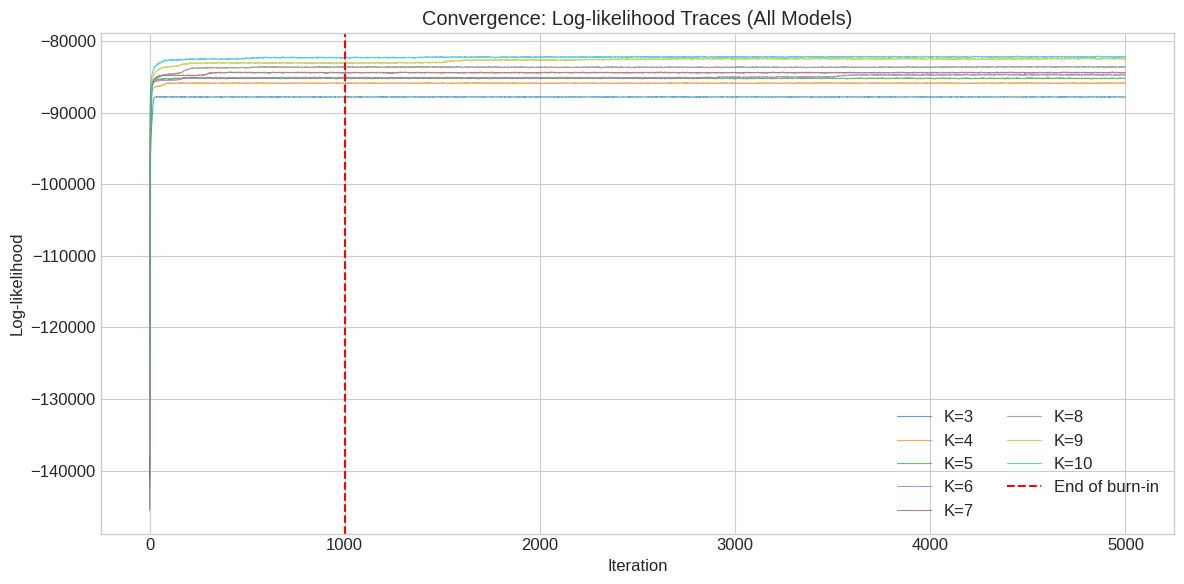

Saved: output/figures/03_convergence_individual.png


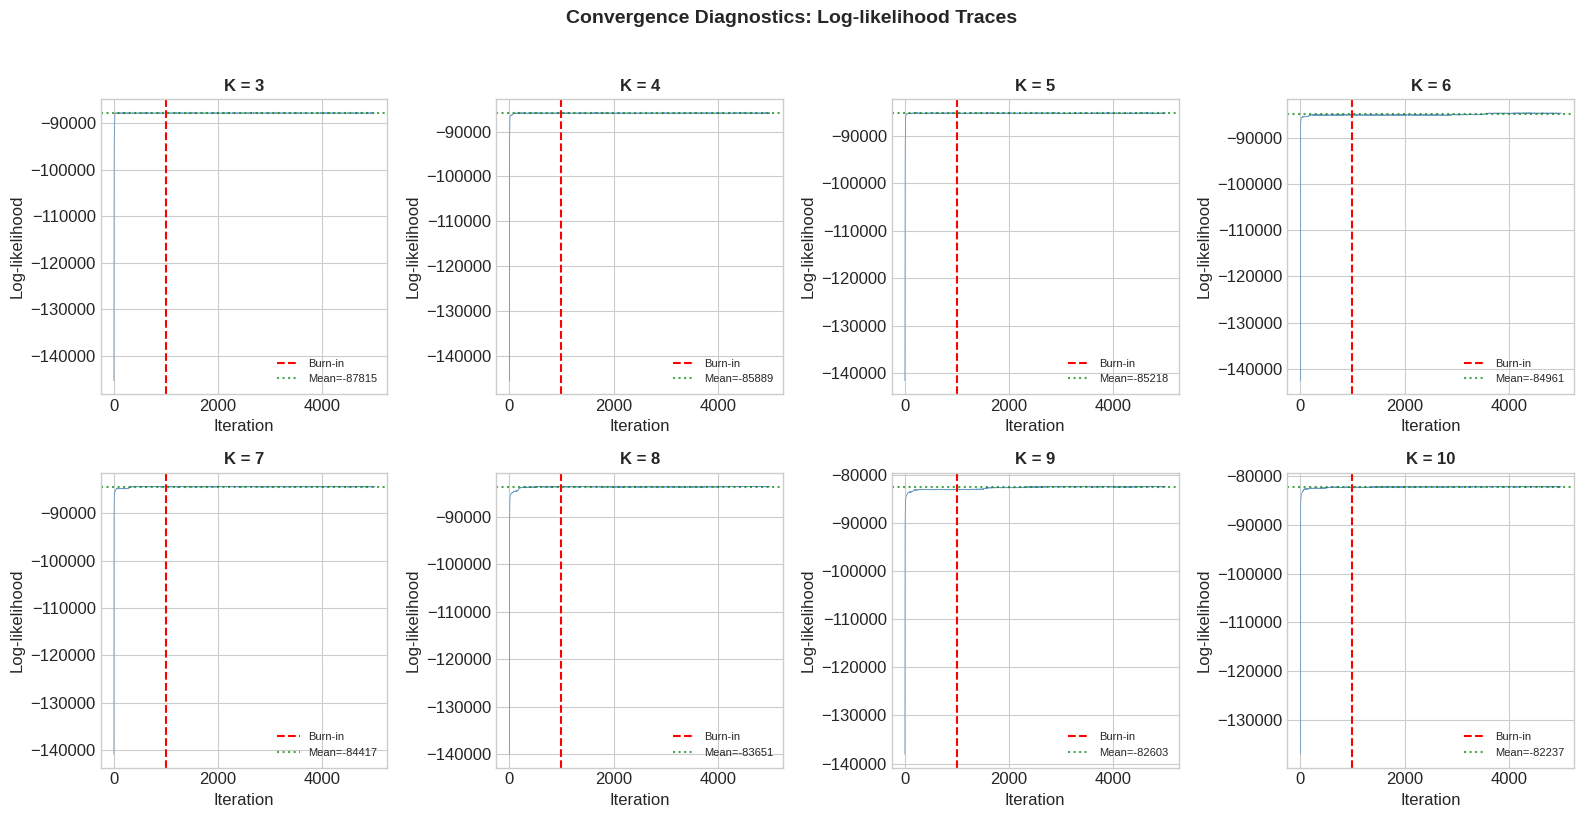

Saved: output/figures/04_convergence_weights.png


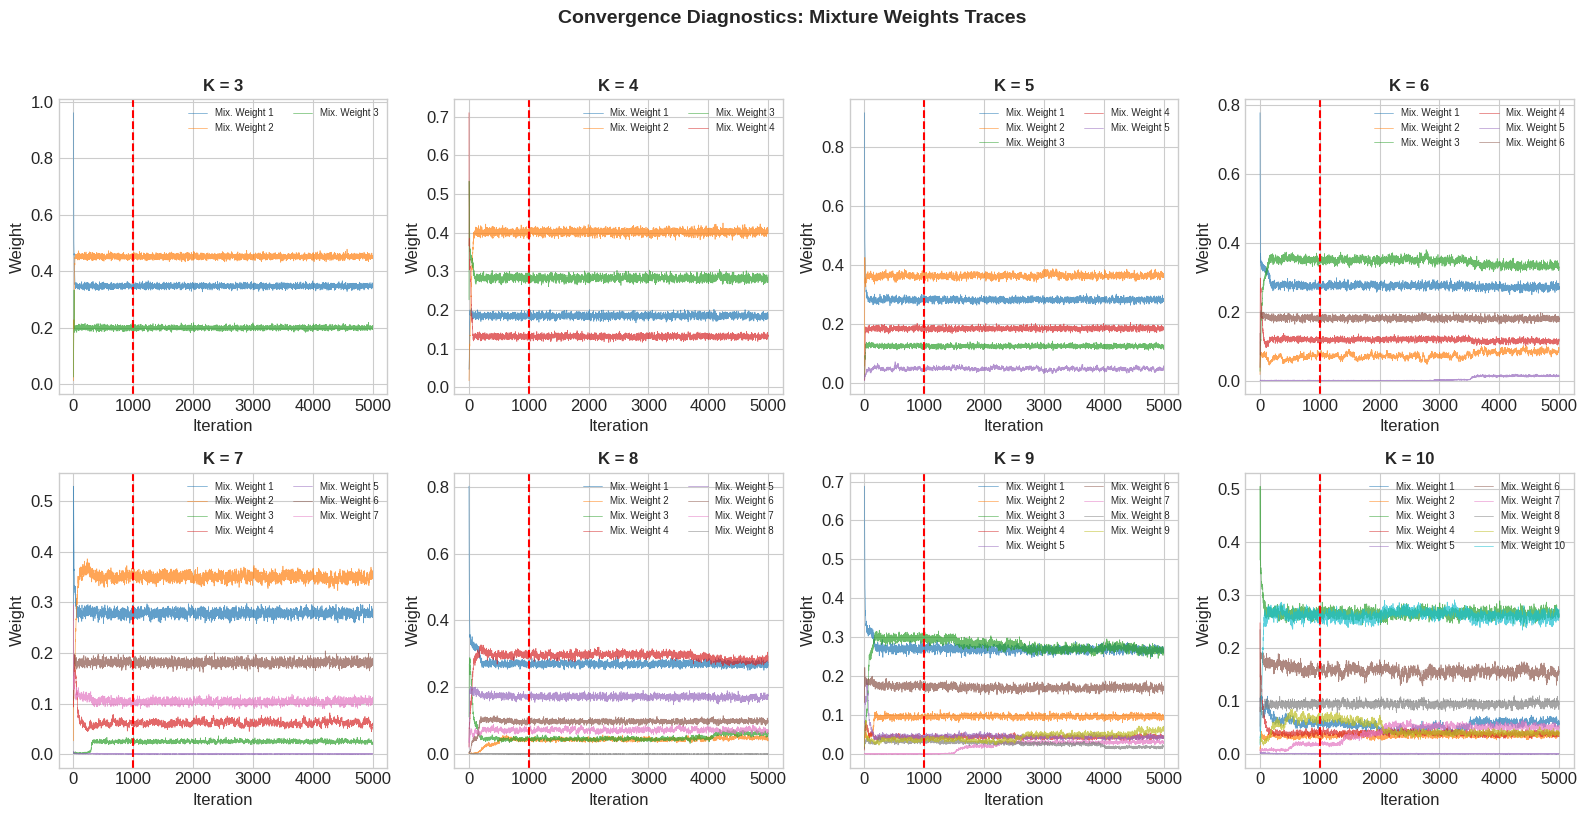

In [20]:
def _create_trace_grid(K_values, n_cols=4, fig_height_per_row=4):
    """We create a grid of subplots for trace plots."""
    n_models = len(K_values)
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, fig_height_per_row * n_rows))
    axes = axes.flatten()
    
    return fig, axes, n_models


def _finalize_trace_grid(fig, axes, n_models, title, save_path):
    """We finalize and save a trace grid figure."""
    for i in range(n_models, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    save_figure(fig, save_path)
    plt.show()


def plot_convergence_summary(results, K_values, burn_in, save_path=None):
    """We plot log-likelihood traces for all K values overlaid."""
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(K_values)))
    
    for i, K in enumerate(K_values):
        trace = results[K]['trace']['log_likelihood']
        ax.plot(trace, alpha=0.7, linewidth=0.8, color=colors[i], label=f'K={K}')
    
    ax.axvline(burn_in, color='red', linestyle='--', label='End of burn-in')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Log-likelihood')
    ax.set_title('Convergence: Log-likelihood Traces (All Models)')
    ax.legend(loc='lower right', ncol=2)
    
    plt.tight_layout()
    save_figure(fig, save_path)
    plt.show()


def plot_individual_traces(results, K_values, burn_in, save_path=None):
    """We plot log-likelihood trace for each K in a grid."""
    fig, axes, n_models = _create_trace_grid(K_values)
    
    for i, K in enumerate(K_values):
        ax = axes[i]
        trace_ll = results[K]['trace']['log_likelihood']
        post_burnin_mean = trace_ll[burn_in:].mean()
        
        ax.plot(trace_ll, linewidth=0.5, alpha=0.8, color='steelblue')
        ax.axvline(burn_in, color='red', linestyle='--', linewidth=1.5, label='Burn-in')
        ax.axhline(post_burnin_mean, color='green', linestyle=':', alpha=0.7, label=f'Mean={post_burnin_mean:.0f}')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Log-likelihood')
        ax.set_title(f'K = {K}', fontsize=12, fontweight='bold')
        ax.legend(loc='lower right', fontsize=8)
    
    _finalize_trace_grid(fig, axes, n_models, 'Convergence Diagnostics: Log-likelihood Traces', save_path)


def plot_weights_traces(results, K_values, burn_in, save_path=None):
    """We plot mixture weights trace for each K in a grid."""
    fig, axes, n_models = _create_trace_grid(K_values)
    
    for i, K in enumerate(K_values):
        ax = axes[i]
        trace_pi = results[K]['trace']['pi']
        
        for k in range(K):
            ax.plot(trace_pi[:, k], linewidth=0.5, alpha=0.7, label=f'Mix. Weight {k+1}')
        
        ax.axvline(burn_in, color='red', linestyle='--', linewidth=1.5)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Weight')
        ax.set_title(f'K = {K}', fontsize=12, fontweight='bold')
        ax.legend(loc='upper right', fontsize=7, ncol=2)
    
    _finalize_trace_grid(fig, axes, n_models, 'Convergence Diagnostics: Mixture Weights Traces', save_path)


# We plot all convergence diagnostics
plot_convergence_summary(results, K_VALUES, BURN_IN, FIGURES_DIR / '02_convergence_traces.png')
plot_individual_traces(results, K_VALUES, BURN_IN, FIGURES_DIR / '03_convergence_individual.png')
plot_weights_traces(results, K_VALUES, BURN_IN, FIGURES_DIR / '04_convergence_weights.png')

---
## Model Comparison and Selection

With all models fitted, we now compare them using BIC to select the optimal number of clusters.

The comparison table shows log-likelihood (fit quality) and BIC (fit quality penalized for complexity) for each K. The best model minimizes BIC, balancing these considerations.

The bar chart provides a visual summary of this comparison, with the selected model highlighted in green. We're looking for a clear "elbow" or minimum in the BIC curve. If the curve is relatively flat across several K values, it suggests the data doesn't strongly prefer one particular number of clusters—in such cases, we might favor parsimony (smaller K) or interpretability.

Interpreting the results: The optimal K represents the model complexity that best explains the data without overfitting. However, BIC is not infallible—it's one principled approach among several, and domain knowledge should also inform our choice. For galaxy morphology, we expect a small number of major types (ellipticals, spirals) with possible subtypes.

Model Comparison:
   K |      Log-Lik |          BIC | Best


   3 |    -87814.85 |    179716.52 | 
   4 |    -85889.24 |    177230.55 | +
   5 |    -85217.95 |    177253.22 | 
   6 |    -84961.16 |    178104.89 | 
   7 |    -84417.21 |    178382.23 | 
   8 |    -83651.13 |    178215.33 | 
   9 |    -82603.04 |    177484.40 | 
  10 |    -82237.41 |    178118.39 | 

Best: K = 4
Saved: output/figures/05_bic_comparison.png


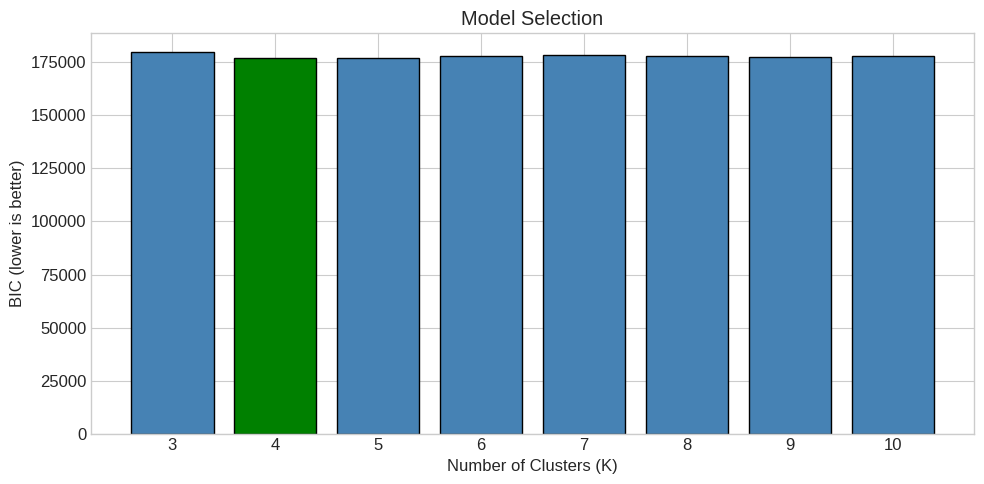

In [22]:
# We find the best K
best_K = min(results, key=lambda k: results[k]['bic'])
best_model = results[best_K]['model']
best_samples = results[best_K]['samples']

# We print the comparison
print("Model Comparison:")
print(f"{'K':>4} | {'Log-Lik':>12} | {'BIC':>12} | Best")
print("\n")
for K in K_VALUES:
    r = results[K]
    marker = "+" if K == best_K else ""
    print(f"{K:>4} | {r['mean_log_lik']:>12.2f} | {r['bic']:>12.2f} | {marker}")

print(f"\nBest: K = {best_K}")

# We plot BIC comparison
fig, ax = plt.subplots(figsize=(10, 5))
bics = [results[K]['bic'] for K in K_VALUES]
colors = ['green' if K == best_K else 'steelblue' for K in K_VALUES]
ax.bar(list(K_VALUES), bics, color=colors, edgecolor='black')
ax.set_xlabel('Number of Clusters (K)')
ax.set_ylabel('BIC (lower is better)')
ax.set_title('Model Selection')
ax.set_xticks(list(K_VALUES))
plt.tight_layout()
save_figure(fig, FIGURES_DIR / '05_bic_comparison.png')
plt.show()

---
## Best Model Summary

Now we examine the details of our selected model. This summary includes:

Mixture Weights ($\pi$): These represent the prior probability of a randomly selected galaxy belonging to each cluster. They tell us about the relative abundance of different galaxy types in our sample. The +/- values are posterior standard deviations, quantifying our uncertainty about these proportions.

Cluster Sizes: The actual number of galaxies assigned to each cluster (based on the modal assignment across posterior samples). This differs slightly from what we'd expect from the mixture weights due to the discrete nature of assignments.

A well-behaved model should have:
- No empty or near-empty clusters (suggesting overparameterization)
- Reasonable uncertainty estimates (neither too narrow nor too wide)
- Cluster sizes roughly proportional to mixture weights

Extremely unequal cluster sizes might indicate that some clusters capture rare but distinct galaxy types, or that the clustering is being driven by outliers—both warrant further investigation.

In [23]:
print(f"Best Model: K = {best_K}")
print("\n")

print("Mixture Weights:")
for k in range(best_K):
    mean = best_model.posterior_pi[k]
    std = best_samples['pi'][:, k].std()
    print(f"  Cluster {k+1}: {mean:.4f} +/- {std:.4f}")

print("\n")
print("Cluster Sizes:")
sizes = np.bincount(best_model.final_assignments, minlength=best_K)
for k in range(best_K):
    print(f"  Cluster {k+1}: {sizes[k]:,} ({100*sizes[k]/N:.1f}%)")

Best Model: K = 4


Mixture Weights:
  Cluster 1: 0.1845 +/- 0.0052
  Cluster 2: 0.4016 +/- 0.0061
  Cluster 3: 0.2825 +/- 0.0061
  Cluster 4: 0.1314 +/- 0.0044


Cluster Sizes:
  Cluster 1: 1,383 (18.4%)
  Cluster 2: 3,004 (40.0%)
  Cluster 3: 2,132 (28.4%)
  Cluster 4: 985 (13.1%)


---
## Cluster Visualization Panels

To effectively communicate our clustering results, we create several reusable visualization functions. These "panel" functions each render a specific aspect of the data:

**`create_panel_clusters`**: Shows the t-SNE projection colored by our discovered cluster assignments. Each point is a galaxy, colored by its cluster membership. This visualizes the structure our GMM has found.

**`create_panel_binary`**: Shows the same projection colored by Galaxy Zoo classifications (smooth vs. disk). This serves as a "ground truth" comparison—if our clusters correspond to real morphological types, they should roughly align with these human classifications.

**`create_panel_psmooth`**: Shows the continuous P(smooth) values from Galaxy Zoo. Unlike the binary view, this reveals the gradual transition between galaxy types and helps us understand which clusters capture intermediate or uncertain cases.

By placing these panels side-by-side, we can visually assess how well our unsupervised clusters correspond to established morphological categories. Perfect alignment isn't expected (galaxies have more than two types, and our VAE might capture features beyond traditional classifications), but strong correspondence validates our approach.

In [24]:
# We define cluster colors once for consistency
MAX_K = max(K_VALUES)
CLUSTER_COLORS = plt.cm.tab10(np.linspace(0, 1, MAX_K))


def create_panel_clusters(ax, Z_tsne, assignments, K, bic, is_best):
    """We draw the clusters panel."""
    for k in range(K):
        mask = (assignments == k)
        ax.scatter(Z_tsne[mask, 0], Z_tsne[mask, 1], c=[CLUSTER_COLORS[k]], label=f'{k+1}', **SCATTER_STYLE)
    
    ax.legend(title='Cluster', loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9, markerscale=2)
    
    title = f'K = {K}  |  BIC = {bic:,.0f}'
    if is_best:
        ax.set_title(f'{title} (Best)', fontsize=14, fontweight='bold', color='green')
    else:
        ax.set_title(title, fontsize=14, fontweight='bold')


def create_panel_binary(ax, Z_tsne, metadata):
    """We draw the Galaxy Zoo labels panel."""
    colors = metadata['is_smooth'].map({True: 'red', False: 'blue'})
    ax.scatter(Z_tsne[:, 0], Z_tsne[:, 1], c=colors, **SCATTER_STYLE)
    ax.legend(handles=[
        Patch(facecolor='red', alpha=0.7, label='Smooth'),
        Patch(facecolor='blue', alpha=0.7, label='Disk')
    ])
    ax.set_title('Galaxy Zoo Labels')


def create_panel_psmooth(ax, Z_tsne, metadata):
    """We draw the P(smooth) panel."""
    sc = ax.scatter(Z_tsne[:, 0], Z_tsne[:, 1], c=metadata['p_smooth'], cmap='coolwarm', **SCATTER_STYLE)
    plt.colorbar(sc, ax=ax, label='P(smooth)')
    ax.set_title('P(smooth)')

---
## Animated GIF of Cluster Evolution

One of the most instructive ways to understand the effect of K on clustering is to watch how the cluster structure evolves as we increase the number of clusters. This animated GIF cycles through $K = 3, 4, \ldots, 10$, showing:

- Left panel: Our discovered clusters for each K, with BIC value displayed
- Middle panel: Galaxy Zoo binary classifications (constant reference)
- Right panel: Galaxy Zoo P(smooth) values (constant reference)

The animation helps build intuition for why BIC penalizes overly complex models: beyond a certain point, adding clusters doesn't reveal new structure—it just subdivides existing groups arbitrarily.

In [25]:
def create_cluster_gif(Z_tsne, results, K_values, metadata, save_path, duration=2000):
    """We create an animated GIF showing how clusters evolve as K increases."""
    best_K = min(results, key=lambda k: results[k]['bic'])
    frames = []
    
    for K in K_values:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        model = results[K]['model']
        is_best = (K == best_K)
        
        create_panel_clusters(axes[0], Z_tsne, model.final_assignments, K, results[K]['bic'], is_best)
        create_panel_binary(axes[1], Z_tsne, metadata)
        create_panel_psmooth(axes[2], Z_tsne, metadata)
        set_axis_labels(axes)
        
        plt.tight_layout()
        frames.append(figure_to_image(fig))
        plt.close(fig)
    
    frames[0].save(save_path, save_all=True, append_images=frames[1:], duration=duration, loop=0)
    print(f"Saved: {save_path}")


create_cluster_gif(Z_tsne, results, K_VALUES, metadata, FIGURES_DIR / '06_cluster_evolution.gif')

Saved: output/figures/06_cluster_evolution.gif


---
## Static Cluster Comparison (Best K)

While the animated GIF is great for exploration, for presentations and publications we need a static comparison figure showing our best model.

This three-panel figure places our discovered clusters alongside the Galaxy Zoo ground truth, enabling direct visual comparison:

- Can we see distinct regions in t-SNE space?
- Do our cluster boundaries roughly follow morphological boundaries?
- Where do they disagree? These regions might represent intermediate galaxy types, classification uncertainty, or features our VAE captures that aren't reflected in the simple smooth/disk dichotomy.

Note that perfect agreement isn't our goal. Galaxy Zoo uses a binary classification, but real galaxies exist on a continuum. Our GMM might capture more nuanced structure (for example: distinguishing face-on from edge-on spirals, or barred from unbarred spirals) that Galaxy Zoo's simplified scheme doesn't address.

Saved: output/figures/07_cluster_comparison.png


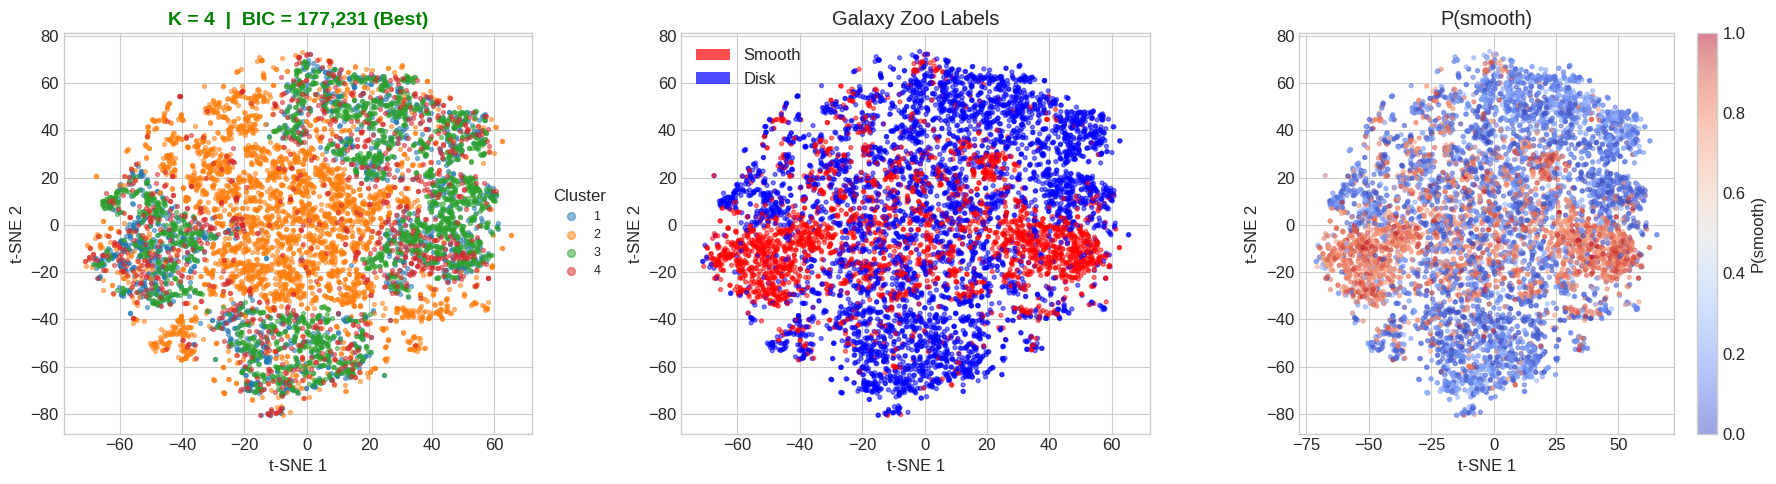

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

create_panel_clusters(axes[0], Z_tsne, best_model.final_assignments, best_K, results[best_K]['bic'], True)
create_panel_binary(axes[1], Z_tsne, metadata)
create_panel_psmooth(axes[2], Z_tsne, metadata)
set_axis_labels(axes)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / '07_cluster_comparison.png')
plt.show()

---
## Quantitative Evaluation

Visual inspection is important, but we also need quantitative metrics to rigorously evaluate our clustering. We compute several standard measures:

### External Validation Metrics

These compare our clusters to the Galaxy Zoo labels:

**[Adjusted Rand Index (ARI)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)**: Measures the similarity between two clusterings, adjusted for chance. Ranges from -1 to 1, where:
- 1 = perfect agreement
- 0 = random labeling
- <0 = worse than random

**[Normalized Mutual Information (NMI)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html)**: Measures the mutual information between clusterings, normalized to [0, 1]. Higher values indicate that knowing one clustering helps predict the other.

### Internal Validation Metrics

These evaluate cluster quality without reference to external labels:

**Variance Ratio (between/within)**: Compares variance between cluster centers to variance within clusters.

### Interpretation

ARI and NMI near zero mean our 4 GMM clusters do not correspond to the smooth vs. disk classification—the clustering found structure unrelated to morphology. The low variance ratio (2%) indicates the clusters aren't capturing well-separated regions in latent space. Essentially, our VAE latent representations encode something other than the morphological features Galaxy Zoo volunteers used to classify galaxies.

In [27]:
def evaluate_clustering(Z, assignments, true_labels, K):
    """We compute clustering quality metrics."""
    ari = adjusted_rand_score(true_labels, assignments)
    nmi = normalized_mutual_info_score(true_labels, assignments)
    
    global_mean = Z.mean(axis=0)
    
    within_var = sum(
        np.var(Z[assignments == k], axis=0).sum() * (assignments == k).sum()
        for k in range(K) if (assignments == k).sum() > 0
    ) / len(Z)
    
    between_var = sum(
        (assignments == k).sum() * np.sum((Z[assignments == k].mean(axis=0) - global_mean)**2)
        for k in range(K) if (assignments == k).sum() > 0
    ) / len(Z)
    
    return {'ari': ari, 'nmi': nmi, 'within_var': within_var, 'between_var': between_var}


true_labels = metadata['is_smooth'].astype(int).values
metrics = evaluate_clustering(Z, best_model.final_assignments, true_labels, best_K)

print("Clustering Quality:")
print(f"\tARI: {metrics['ari']:.4f}")
print(f"\tNMI: {metrics['nmi']:.4f}")
print(f"\tVariance ratio: {metrics['between_var']/metrics['within_var']:.4f}")

Clustering Quality:
	ARI: 0.0034
	NMI: 0.0013
	Variance ratio: 0.0202


---
## Cluster Interpretation

Now we dig into what each cluster actually represents in terms of galaxy morphology. For each cluster, we examine the distribution of P(smooth) values among its members.

Our interpretation scheme:

| Mean P(smooth) | Interpretation |
|----------------|----------------|
| > 0.6 | Mostly Elliptical: These galaxies have smooth, featureless light profiles typical of elliptical galaxies |
| < 0.3 | Mostly Spiral: These galaxies show disk structure, spiral arms, and other features |
| 0.3 - 0.6 | Mixed: Either lenticular galaxies (transitional type), edge-on disks (hard to classify), or uncertain cases |

The standard deviations in P(smooth) tell us about cluster purity:
- Low standard deviation: Homogeneous cluster (all members are similar)
- High standard deviation: Diverse cluster (members span a range of morphologies)

In [28]:
def interpret_clusters(assignments, metadata, K):
    """We analyze the morphological composition of each cluster."""
    rows = []
    
    for k in range(K):
        mask = (assignments == k)
        cluster = metadata[mask]
        p_mean = cluster['p_smooth'].mean()
        
        if p_mean > 0.6:
            interp = "Mostly ELLIPTICAL"
        elif p_mean < 0.3:
            interp = "Mostly SPIRAL"
        else:
            interp = "MIXED"
        
        rows.append({
            'Cluster': k + 1,
            'Size': mask.sum(),
            'P(smooth)': f"{p_mean:.3f} +/- {cluster['p_smooth'].std():.3f}",
            'Interpretation': interp
        })
    
    return pd.DataFrame(rows)


cluster_analysis = interpret_clusters(best_model.final_assignments, metadata, best_K)
print(cluster_analysis.to_string(index=False))

 Cluster  Size       P(smooth) Interpretation
       1  1383 0.401 +/- 0.354          MIXED
       2  3004 0.366 +/- 0.345          MIXED
       3  2132 0.350 +/- 0.339          MIXED
       4   985 0.382 +/- 0.350          MIXED


---
## Posterior Uncertainty

A key advantage of our Bayesian approach is that we obtain full posterior distributions, not just point estimates. This section visualizes the uncertainty in our mixture weight estimates.

For each cluster, we plot a histogram of the posterior samples of π_k (the mixture weight). These distributions show:

- Location: The most likely value for each weight (vertical red line shows the mean)
- Spread: Our uncertainty about the true value—wider distributions indicate more uncertainty
- Shape: Roughly bell-shaped distributions suggest good MCMC mixing and adequate sample size

This uncertainty quantification is scientifically valuable: when we report that "Cluster 3 contains 25% of galaxies," we can now attach a credible interval (e.g., "22-28% with 95% probability") rather than presenting a single point estimate.

Saved: output/figures/08_posterior_weights.png


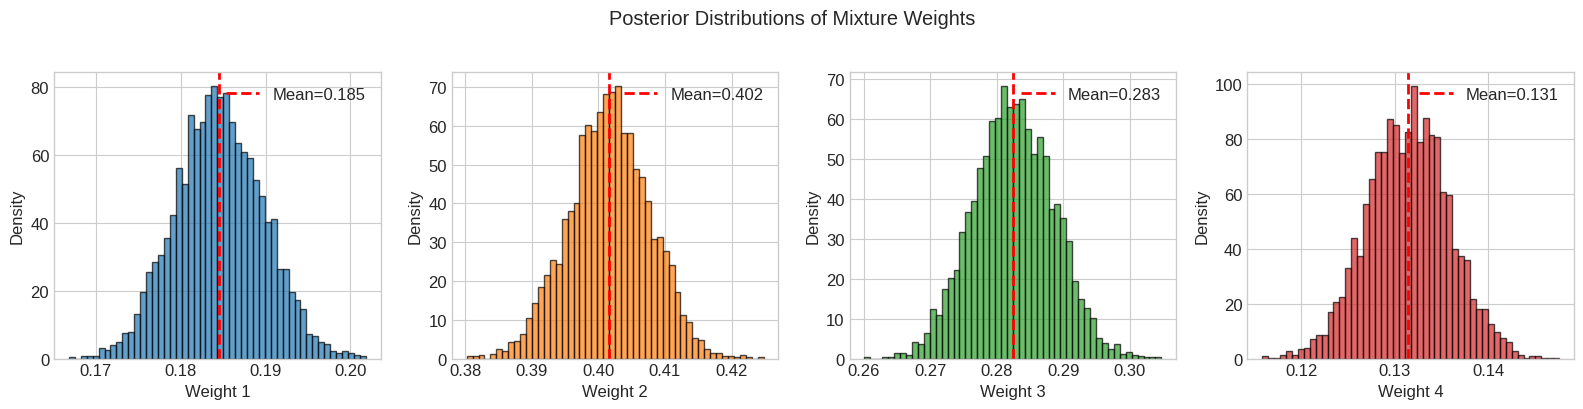

In [29]:
def plot_posterior_weights(samples, posterior_mean, K, save_path=None):
    """We visualize posterior distributions of mixture weights."""
    fig, axes = plt.subplots(1, K, figsize=(4 * K, 4))
    if K == 1:
        axes = [axes]
    
    for k, ax in enumerate(axes):
        ax.hist(samples['pi'][:, k], bins=50, density=True, alpha=0.7, color=CLUSTER_COLORS[k], edgecolor='black')
        ax.axvline(posterior_mean[k], color='red', linestyle='--', linewidth=2, label=f'Mean={posterior_mean[k]:.3f}')
        ax.set_xlabel(f'Weight {k+1}')
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.suptitle('Posterior Distributions of Mixture Weights', y=1.02)
    plt.tight_layout()
    save_figure(fig, save_path)
    plt.show()


plot_posterior_weights(best_samples, best_model.posterior_pi, best_K, FIGURES_DIR / '08_posterior_weights.png')

---
## $P_{smooth}$ by Cluster

To further characterize our clusters, we visualize the full distribution of $P_{\text{smooth}}$ values within each cluster using violin plots.

### Interpretation Guide

- Tall, narrow violins centered away from 0.5: Homogeneous clusters with clear morphological identity
- Short, wide violins centered at 0.5: Diverse clusters spanning both types (transitional or uncertain)
- Bimodal violins: Might indicate sub-structure within the cluster that our K-value couldn't capture

This visualization helps us understand not just the average morphology of each cluster, but the morphological diversity within it—crucial for interpreting whether our clusters represent distinct galaxy populations or arbitrary divisions.

Saved: output/figures/09_psmooth_by_cluster.png


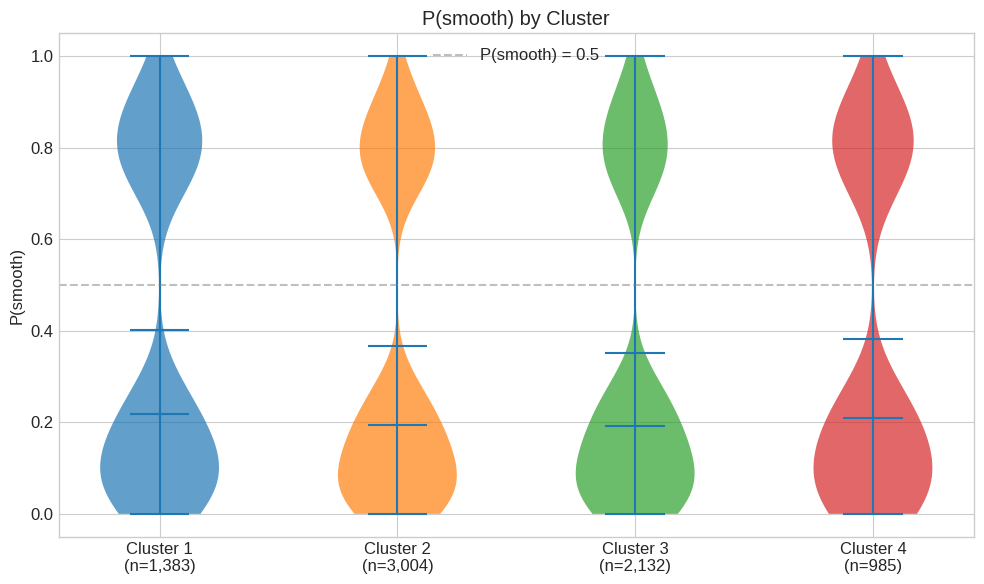

In [30]:
def plot_psmooth_by_cluster(assignments, metadata, K, save_path=None):
    """We show P(smooth) distribution for each cluster."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    data = [metadata.loc[assignments == k, 'p_smooth'].values for k in range(K)]
    labels = [f'Cluster {k+1}\n(n={sum(assignments==k):,})' for k in range(K)]
    
    parts = ax.violinplot(data, showmeans=True, showmedians=True)
    for i, body in enumerate(parts['bodies']):
        body.set_facecolor(CLUSTER_COLORS[i])
        body.set_alpha(0.7)
    
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='P(smooth) = 0.5')
    ax.set_xticks(range(1, K + 1))
    ax.set_xticklabels(labels)
    ax.set_ylabel('P(smooth)')
    ax.set_title('P(smooth) by Cluster')
    ax.legend()
    
    plt.tight_layout()
    save_figure(fig, save_path)
    plt.show()


plot_psmooth_by_cluster(best_model.final_assignments, metadata, best_K, FIGURES_DIR / '09_psmooth_by_cluster.png')

---
## Conditional Generation

One powerful capability of our fitted GMM is conditional generation: we can generate new latent vectors that belong to a specific cluster. This is accomplished by sampling from the learned Gaussian distribution for that cluster.

Here we generate 3,000 latent vectors per cluster. These are not copies of existing galaxies—they are new points sampled from the learned cluster distributions.

### Why This Matters

These generated latent vectors bridge Stages 2 and 3 of our pipeline:

1. **Stage 1**: Images - Latent vectors (VAE encoder)
2. **Stage 2**: Latent vectors - Cluster membership (this notebook's GMM)
3. **Stage 3**: Cluster-conditioned latent vectors - Generated images (VAE decoder)

By passing these generated latent vectors through the VAE decoder (Stage 3), we can:
- Generate new galaxy images of a specific morphological type
- Explore the latent space by seeing what images correspond to different regions

The printed means (first 4 dimensions only, for brevity) give a quick sanity check that the generated samples are centered appropriately for each cluster.

In [31]:
N_SAMPLES_PER_CLUSTER = 3000

generated_samples = {}

print("Conditional Generation")
print(f"Generating {N_SAMPLES_PER_CLUSTER} latent vectors per cluster...")
print()

for k in range(best_K):
    seed = RANDOM_SEED + k
    samples = best_model.sample_from_cluster(k, N_SAMPLES_PER_CLUSTER, random_state=seed)
    generated_samples[k] = samples
    
    mean_str = ', '.join(f'{x:.3f}' for x in samples.mean(axis=0)[:4])
    print(f"\tCluster {k+1}: mean = [{mean_str}, ...]")

Conditional Generation
Generating 3000 latent vectors per cluster...

	Cluster 1: mean = [-0.062, -0.037, -0.246, -0.092, ...]
	Cluster 2: mean = [0.028, 0.012, 0.487, -0.052, ...]
	Cluster 3: mean = [-0.010, -0.013, -0.394, -0.100, ...]
	Cluster 4: mean = [-0.019, -0.032, 0.038, -0.027, ...]


---
## Save Results

To enable downstream analysis and ensure reproducibility, we save all key outputs from this notebook:

**`01_galaxy_clusters.csv`**: The original metadata enriched with cluster assignments. This is the primary output for most downstream analyses—each galaxy now has a cluster label in addition to its Galaxy Zoo classifications.

**`02_gmm_posterior_params.npz`**: The posterior mean parameters ($\pi, \mu, \Sigma$) of our best model. These fully characterize the learned GMM and can be loaded to make predictions on new galaxies or generate new samples without re-running the Gibbs sampler.

**`03_generated_latents_cluster_{k}.npy`**: The conditionally generated latent vectors for each cluster. These are ready to be passed through the VAE decoder in Stage 3.

**`04_model_selection_results.npz`**: BIC and log-likelihood values for all K values tested. This documents our model selection process and allows others to examine alternative models if desired.

In [33]:
# We save cluster assignments
output_df = metadata.copy()
output_df['cluster'] = best_model.final_assignments
output_df.to_csv(TABLES_DIR / '01_galaxy_clusters.csv', index=False)

# We save posterior parameters
np.savez(
    TABLES_DIR / '02_gmm_posterior_params.npz',
    pi=best_model.posterior_pi,
    mu=best_model.posterior_mu,
    Sigma=best_model.posterior_Sigma,
    K=best_K
)

# We save generated samples
for k, samples in generated_samples.items():
    np.save(TABLES_DIR / f'03_generated_latents_cluster_{k+1}.npy', samples)

# We save model selection results
np.savez(
    TABLES_DIR / '04_model_selection_results.npz',
    K_values=list(K_VALUES),
    BIC=[results[K]['bic'] for K in K_VALUES],
    log_likelihood=[results[K]['mean_log_lik'] for K in K_VALUES],
    best_K=best_K
)

print("Saved files:")
for f in sorted(TABLES_DIR.glob('*')):
    print(f"- {f.name}")

Saved files:
- .gitkeep
- 01_galaxy_clusters.csv
- 02_gmm_posterior_params.npz
- 03_generated_latents_cluster_1.npy
- 03_generated_latents_cluster_2.npy
- 03_generated_latents_cluster_3.npy
- 03_generated_latents_cluster_4.npy
- 04_model_selection_results.npz
